In [3]:
import pandas as pd
from ivpy import attach,show,montage,histogram,scatter,compose
from ivpy.extract import extract
from ivpy.reduce import pca,tsne,umap
from ivpy.cluster import cluster
from ivpy.extract import norm
from sklearn.metrics import adjusted_rand_score as adjrand

In [4]:
DIR = "/mnt/e/Tasks/similarity/Images/Situated-Views-Lowres/" 
df = pd.read_csv("/mnt/e/Tasks/similarity/src/output/metadata.csv")

In [ ]:
attach(df,'path')

# extract( )

In [5]:
df = df.iloc[:50]
#df.set_index("Source ID", inplace=True)
attach(df,'path')

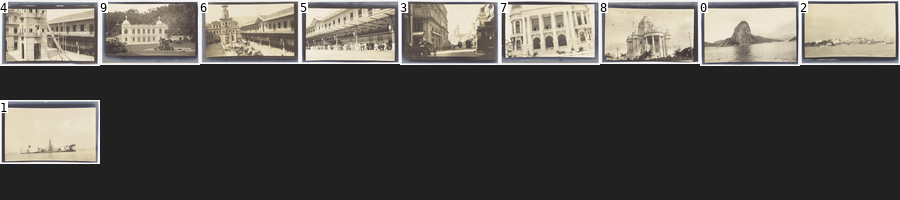

In [7]:
show(xcol="entropy",thumb=100, idx=True)

I included basic color features in oxfordflower.csv, to show off the plotting functions. But now we can extract those features ourselves with `extract()`. All you need to pass to extract is the image filepaths, and a keyword telling ivpy which feature to extract. Currently, the options are 'brightness', 'saturation', 'hue', 'entropy', 'std', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation', 'neural', 'tags', or 'dmax'. Since we've already looked at the HSV properties, let's check out the others.

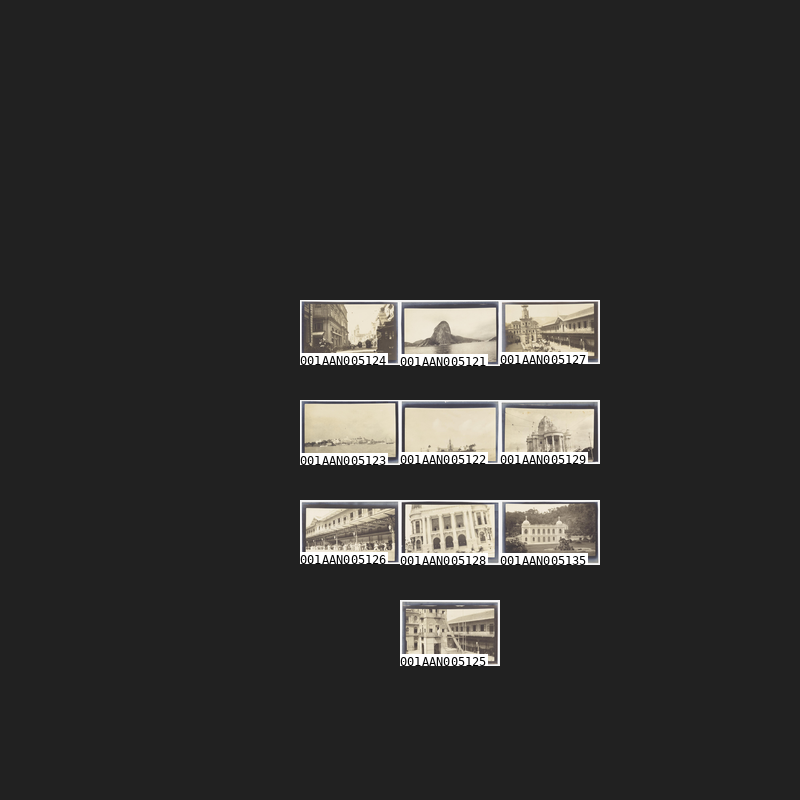

In [20]:
montage(xcol='entropy',shape='circle',ascending=True,notecol="Source ID")

In [ ]:
show(xcol="entropy",thumb=150, notecol="Source ID")

There are better datasets for illustrating entropy, but by looking at the middle of the plot, we can see that low entropy images are "simpler" or more "minimalist", and the high entropy images at the outer edge are "noisier". I won't march through all of the examples, but entropy, standard deviation, contrast, dissimilarity, homogeneity, ASM, energy, and correlation are all texture properties derived from the gray-level co-occurrence matrix (GLCM). For more information, visit the scikit-image page: https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html

## Neural net similarity

Neural nets are all the rage now, and a neural net measure of similarity can be a great starting point for exploring your image collections. Moreover, because the neural net extractor delivers a high-dimensional vector, rather than a single number, we can test out our dimension reduction and clustering algorithms. Ivpy's neural net vector is the output of the penultimate layer of ResNet50: https://arxiv.org/abs/1512.03385

In [6]:
X = extract('neural')

5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 

First, let's normalize the vector space using extract.norm:

In [7]:
X = norm(X)

# cluster()

First, let's start by clustering in the high-dimensional space. Since there are 17 flower names, let's set the number of clusters to 17. If we pass no keyword argument for 'method', the method will be k-means:

In [12]:
df['cluster_kmeans'] = cluster(X,k=2)

method: kmeans 
number of clusters: 2


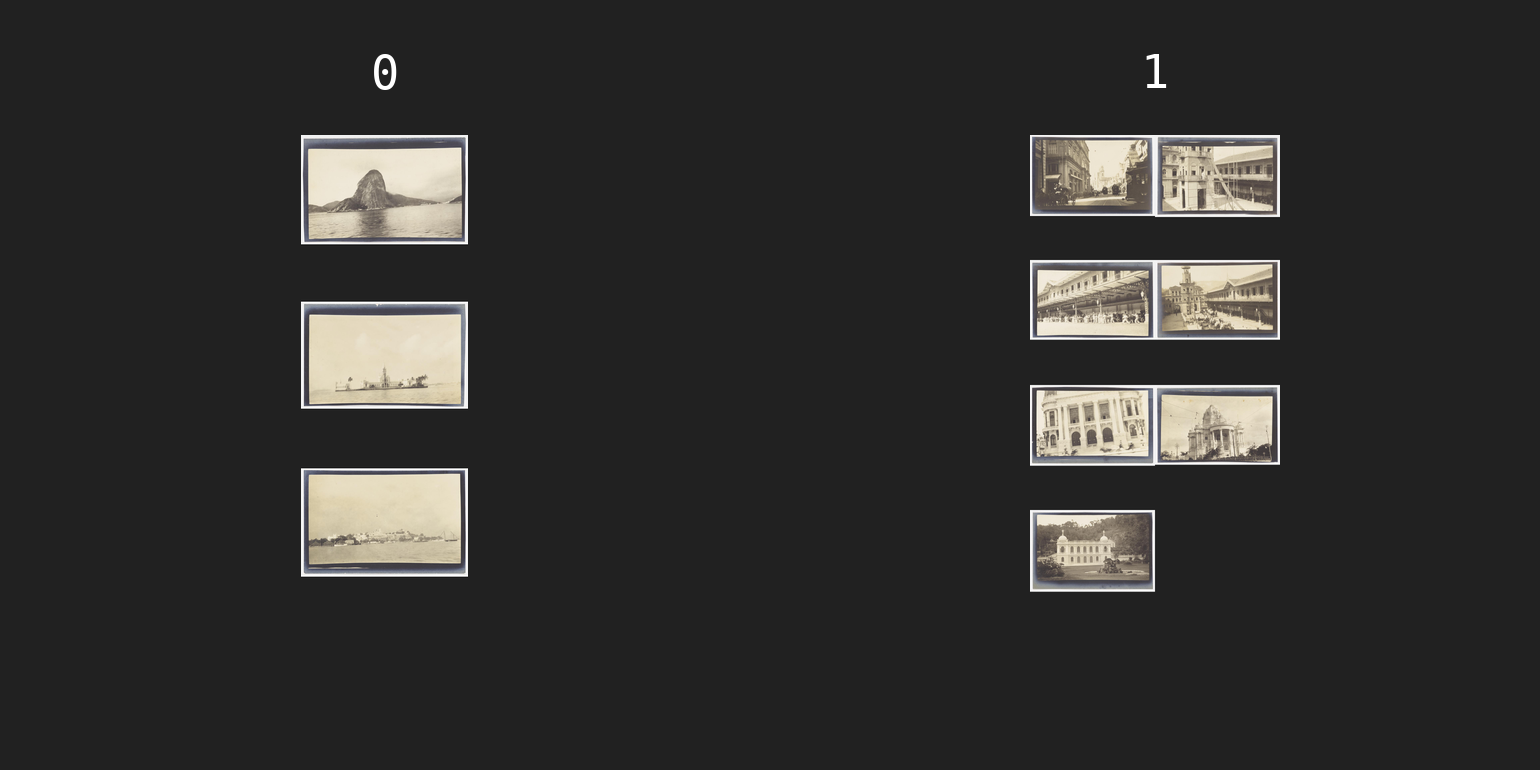

In [24]:
montage(facetcol='cluster_kmeans', thumb=500)

Not too bad! Let's see how well this purely visual clustering accords with the actual flower names:

In [9]:
from ivpy.analysis import nearest
nearest(X, i=20, k=30, thumb=200, notecol="Source ID")

ModuleNotFoundError: No module named 'annoy'

In [ ]:
d = dict(zip(list(df.Creator.unique()),list(range(len(df.Creator.unique())))))

In [ ]:
df['flower_number'] = [d[item] for item in df.Creator]

In [ ]:
adjrand(df.flower_number,df.cluster_kmeans)

The adjusted rand score measures the similarity of two clusterings. A score of 1.0 means a perfect match, and random is about zero. So, 0.47 is not too bad! This means that there is some flower name signal in the purely visual data, but it does not provide a perfect discriminator. For fun, we could zoom into a heterogeneous cluster to see what's going on:

In [ ]:
for cluster_number in df.cluster_kmeans.unique():
    tmp = df.Creator[df.cluster_kmeans==cluster_number]
    n = len(tmp.unique())
    print(cluster_number,":",n)

Let's look at cluster 3. From the plot above, we can see it looks pretty visually unified, but there are 10 different flower names in there!

In [ ]:
montage(pathcol=df.filename[df.cluster_kmeans==3],notecol=df.Creator[df.cluster_kmeans==3])

Ah ok. In addition to daffodils, there are yellow tulips, sunflowers, cowslips, buttercups, and more.

# reduce

Ok that was fun. But now let's just look at all the images on the same plotting canvas, by reducing the 2048 dimensions of the ResNet50 vector down to 2. We can actually look at 3 different algorithms, and can make a triptych of plots with a loop:

In [ ]:
plotlist = []
for func in [pca,tsne,umap]:
    df[['x','y']] = func(X,n_components=2)
    plotlist.append(scatter('x','y',side=800,xbins=40,ybins=40,thumb=20))
compose(*plotlist,ncols=3,border=True)

The t-SNE plot (middle) looks pretty interesting. Let's take a closer look. We will remove the gridding:

In [ ]:
df[['x','y']] = tsne(X)
scatter('x','y',side=4000,thumb=64)

Looks good! We have some pretty clear flower neighborhoods here, and maybe have the very beginnings of a simple K-Nearest-Neighbors flower classifier?

Just a note on the reducing functions: they all use the scikit-learn API, including keywords. Ivpy is really just a thin wrapper around scikit-learn's already concise API. Usually, these functions will default to 2 dimensions, but you must pass `n_components=2` to `pca()`; it's default is 1360.